In [1]:
from numpy.random import seed
seed(35)
from tensorflow import set_random_seed
set_random_seed(35)


from secTools import yamlLoad
from general_loader import ds_from_db
from data_manipulation import remove_outlier,augment_x
import numpy as np
from secTools import yamlLoad
from sklearn.model_selection import train_test_split

from keras.initializers import glorot_uniform, glorot_normal
from keras.optimizers import Adam
import keras.backend as K
from keras.utils import plot_model
from keras.callbacks import EarlyStopping


from custom_loss import (recon_loss_abs, make_recon_loss_combi,sparse_recon_loss_abs,
                         make_sparse_recon_loss_combi,sparse_recon_loss_mse)

from Autoencoders import (autoencoder,fit_model_dic,plot_loss_dic,
                          create_loss_param_table,save_ae_history,
                          save_ae_dic,make_ae_dict_from_dict,model_node_wrap,
                          load_ae_dic, load_ae_weights)

from ae_designs_depth import model_3h


import matplotlib.pyplot as plt
import os

import pandas as pd

import yaml

from matplotlib.pyplot import hist

from data_manipulation import augment_x_linear

/home/anywayed/anaconda3/envs/keras/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:

ds_dic={'pickle_file':'ds180704'}
ds=ds_from_db(**ds_dic)


In [3]:
ds.normalise(['pAssets','pLiabilitiesAndStockholdersEquity'],reorder=True,inplace=True)
ds.normalise(['pAssets','pLiabilitiesAndStockholdersEquity'],reorder=True,inplace=True)

#I can't figure out why I need to do this twice. 


Number of records dropped where no normaliser: 326
Number of records dropped where no normaliser: 119


In [4]:
def checker(df2):
    return df2[(df2.pAssets!=1)&(df2.pLiabilitiesAndStockholdersEquity!=1)]
#checker(ds.FT.dropna())
checker(ds.FT)

,tag,Assets,pAssets,pCashAndCashEquivalentsAtCarryingValue,CashAndCashEquivalentsAtCarryingValue,LiabilitiesAndStockholdersEquity,pLiabilitiesAndStockholdersEquity,NetIncomeLoss,pNetIncomeLoss,pStockholdersEquity,StockholdersEquity,...,IncreaseDecreaseInOtherNoncurrentLiabilities,pIncreaseDecreaseInOtherNoncurrentLiabilities,pCapitalLeaseObligationsIncurred,pStockRepurchasedDuringPeriodValue,CapitalLeaseObligationsIncurred,StockRepurchasedDuringPeriodValue,OtherSalesRevenueNet,pOtherSalesRevenueNet,ValuationAllowancesAndReservesBalance,pValuationAllowancesAndReservesBalance
adsh,period,,,,,,,,,,,,,,,,,,,,,


In [4]:
X=ds.FT.values
Y=ds.FT.index.values
X=remove_outlier(X,2.5,replace_nan=True)

assert(~np.any(np.isnan(X)))

X=X[:,0:200]
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=35)



/home/anywayed/Documents/dis/secTools/data_manipulation.py:31: RuntimeWarning: invalid value encountered in greater
  X[np.abs(X)>level_x]=np.nan


In [6]:


#only augment the data once in with each method
x_train_lin_aug=augment_x_linear(x_train,reps=10000,pairs=True)
x_train_lin_aug_aug=augment_x(np.vstack((x_train_lin_aug,x_train)),ds,repeats=4,fit_col='Assets',seed=22)
x_train_aug=augment_x(x_train,ds,repeats=6,fit_col='Assets',seed=22)


#plain data
train_data=[x_train,x_train]
test_data=[x_test,x_test]
original_data_dic={'train_data':train_data,'test_data':test_data}

#training set with only linearly augmented data
x_train_lin_aug=np.vstack((x_train_lin_aug,x_train))
train_data_lin_aug=[x_train_lin_aug,x_train_lin_aug]
lin_aug_data_dic={'train_data':train_data_lin_aug,'test_data':test_data}

#multiplicative augmentation to linearly augmented data
x_train_lin_aug_aug=np.vstack((x_train_lin_aug_aug,x_train))
train_data_lin_aug_aug=[x_train_lin_aug_aug,x_train_lin_aug_aug]
lin_aug_aug_data_dic={'train_data':train_data_lin_aug_aug,'test_data':test_data}

#training set with only multiplicative augmented data
x_train_aug=np.vstack((x_train,x_train_aug))
train_data_aug=[x_train_aug,x_train_aug]
aug_data_dic={'train_data':train_data_aug,'test_data':test_data}


test_data=[x_test,x_test]


there are  1332  with at least one identical pair to compose new financials from


In [7]:
recon_loss_combi=make_recon_loss_combi(0.5)
sparse_recon_loss_combi=make_sparse_recon_loss_combi(0.5)
loss=sparse_recon_loss_combi

metrics=[sparse_recon_loss_mse,sparse_recon_loss_abs]


#early stop setting below is default but explicitly stated here
ES=EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, mode='auto')

opt=Adam(lr=0.001)
ker_init=glorot_normal(seed=22)

train_dic={'loss':loss,
           'compile':True,'epochs':100,'batch_size':512,'optimizer':opt,
          'early_stop':ES,'metrics':metrics}



layer_p_dic={'drop_ra':0.01, 'g_noise':0.05, 'ker_init':ker_init,'nodes':[64,16,64]}


In [33]:
#layers=model_3h(x_train_aug,**layer_p_dic)
#new_train_dic={**train_dic,**aug_data_dic}
#mod_aug=autoencoder(layers,name='3layer_new_mod',**new_train_dic)

In [8]:
nw_names=['original_data','lin_aug_data','lin_aug_aug_data','aug_data']
layer_dic={name:model_3h for name in nw_names}
layer_param_dic={name:layer_p_dic for name in nw_names}
#train_dic={name:train_dic for name in nw_names}
model_data_dic={'original_data':original_data_dic,'lin_aug_data':lin_aug_data_dic,
          'lin_aug_aug_data':lin_aug_aug_data_dic,'aug_data':aug_data_dic,
          }


In [9]:
ae_dic=make_ae_dict_from_dict(layer_dic,layer_param_dic,model_data_dic,train_dic)

In [10]:
fit_model_dic(ae_dic)

lin_aug_data
Train on 31161 samples, validate on 7054 samples
Epoch 1/100
31161/31161 [==============================] - 1s 36us/step - loss: 0.1500 - sparse_recon_loss_mse: 0.1136 - sparse_recon_loss_abs: 0.1864 - val_loss: 0.1144 - val_sparse_recon_loss_mse: 0.0781 - val_sparse_recon_loss_abs: 0.1507
Epoch 2/100
31161/31161 [==============================] - 0s 14us/step - loss: 0.0817 - sparse_recon_loss_mse: 0.0517 - sparse_recon_loss_abs: 0.1116 - val_loss: 0.0870 - val_sparse_recon_loss_mse: 0.0560 - val_sparse_recon_loss_abs: 0.1179
Epoch 3/100
31161/31161 [==============================] - 0s 14us/step - loss: 0.0690 - sparse_recon_loss_mse: 0.0414 - sparse_recon_loss_abs: 0.0966 - val_loss: 0.0733 - val_sparse_recon_loss_mse: 0.0452 - val_sparse_recon_loss_abs: 0.1015
Epoch 4/100
31161/31161 [==============================] - 0s 14us/step - loss: 0.0613 - sparse_recon_loss_mse: 0.0352 - sparse_recon_loss_abs: 0.0875 - val_loss: 0.0648 - val_sparse_recon_loss_mse: 0.0384 - val_

31161/31161 [==============================] - 0s 14us/step - loss: 0.0348 - sparse_recon_loss_mse: 0.0169 - sparse_recon_loss_abs: 0.0527 - val_loss: 0.0375 - val_sparse_recon_loss_mse: 0.0197 - val_sparse_recon_loss_abs: 0.0553
Epoch 35/100
31161/31161 [==============================] - 0s 15us/step - loss: 0.0347 - sparse_recon_loss_mse: 0.0168 - sparse_recon_loss_abs: 0.0525 - val_loss: 0.0373 - val_sparse_recon_loss_mse: 0.0196 - val_sparse_recon_loss_abs: 0.0550
Epoch 36/100
31161/31161 [==============================] - 0s 14us/step - loss: 0.0344 - sparse_recon_loss_mse: 0.0167 - sparse_recon_loss_abs: 0.0521 - val_loss: 0.0371 - val_sparse_recon_loss_mse: 0.0195 - val_sparse_recon_loss_abs: 0.0548
Epoch 37/100
31161/31161 [==============================] - 0s 14us/step - loss: 0.0344 - sparse_recon_loss_mse: 0.0167 - sparse_recon_loss_abs: 0.0521 - val_loss: 0.0369 - val_sparse_recon_loss_mse: 0.0194 - val_sparse_recon_loss_abs: 0.0544
Epoch 38/100
31161/31161 [===============

Epoch 68/100
31161/31161 [==============================] - 0s 14us/step - loss: 0.0313 - sparse_recon_loss_mse: 0.0148 - sparse_recon_loss_abs: 0.0479 - val_loss: 0.0335 - val_sparse_recon_loss_mse: 0.0172 - val_sparse_recon_loss_abs: 0.0498
Epoch 69/100
31161/31161 [==============================] - 0s 15us/step - loss: 0.0314 - sparse_recon_loss_mse: 0.0149 - sparse_recon_loss_abs: 0.0479 - val_loss: 0.0336 - val_sparse_recon_loss_mse: 0.0172 - val_sparse_recon_loss_abs: 0.0499
Epoch 70/100
31161/31161 [==============================] - 0s 14us/step - loss: 0.0312 - sparse_recon_loss_mse: 0.0147 - sparse_recon_loss_abs: 0.0477 - val_loss: 0.0335 - val_sparse_recon_loss_mse: 0.0172 - val_sparse_recon_loss_abs: 0.0498
Epoch 71/100
31161/31161 [==============================] - 0s 14us/step - loss: 0.0311 - sparse_recon_loss_mse: 0.0147 - sparse_recon_loss_abs: 0.0475 - val_loss: 0.0334 - val_sparse_recon_loss_mse: 0.0172 - val_sparse_recon_loss_abs: 0.0495
Epoch 72/100
31161/31161 [==

148127/148127 [==============================] - 2s 13us/step - loss: 0.0351 - sparse_recon_loss_mse: 0.0174 - sparse_recon_loss_abs: 0.0527 - val_loss: 0.0314 - val_sparse_recon_loss_mse: 0.0158 - val_sparse_recon_loss_abs: 0.0470
Epoch 20/100
148127/148127 [==============================] - 2s 13us/step - loss: 0.0350 - sparse_recon_loss_mse: 0.0173 - sparse_recon_loss_abs: 0.0526 - val_loss: 0.0314 - val_sparse_recon_loss_mse: 0.0158 - val_sparse_recon_loss_abs: 0.0469
Epoch 21/100
148127/148127 [==============================] - 2s 13us/step - loss: 0.0348 - sparse_recon_loss_mse: 0.0172 - sparse_recon_loss_abs: 0.0524 - val_loss: 0.0313 - val_sparse_recon_loss_mse: 0.0157 - val_sparse_recon_loss_abs: 0.0469
Epoch 22/100
148127/148127 [==============================] - 2s 13us/step - loss: 0.0346 - sparse_recon_loss_mse: 0.0171 - sparse_recon_loss_abs: 0.0522 - val_loss: 0.0313 - val_sparse_recon_loss_mse: 0.0156 - val_sparse_recon_loss_abs: 0.0470
Epoch 23/100
148127/148127 [=====

21161/21161 [==============================] - 0s 14us/step - loss: 0.0512 - sparse_recon_loss_mse: 0.0284 - sparse_recon_loss_abs: 0.0739 - val_loss: 0.0477 - val_sparse_recon_loss_mse: 0.0258 - val_sparse_recon_loss_abs: 0.0696
Epoch 8/100
21161/21161 [==============================] - 0s 14us/step - loss: 0.0500 - sparse_recon_loss_mse: 0.0275 - sparse_recon_loss_abs: 0.0726 - val_loss: 0.0461 - val_sparse_recon_loss_mse: 0.0249 - val_sparse_recon_loss_abs: 0.0672
Epoch 9/100
21161/21161 [==============================] - 0s 14us/step - loss: 0.0488 - sparse_recon_loss_mse: 0.0267 - sparse_recon_loss_abs: 0.0709 - val_loss: 0.0447 - val_sparse_recon_loss_mse: 0.0239 - val_sparse_recon_loss_abs: 0.0655
Epoch 10/100
21161/21161 [==============================] - 0s 14us/step - loss: 0.0479 - sparse_recon_loss_mse: 0.0261 - sparse_recon_loss_abs: 0.0697 - val_loss: 0.0436 - val_sparse_recon_loss_mse: 0.0233 - val_sparse_recon_loss_abs: 0.0640
Epoch 11/100
21161/21161 [=================

Epoch 41/100
21161/21161 [==============================] - 0s 14us/step - loss: 0.0390 - sparse_recon_loss_mse: 0.0199 - sparse_recon_loss_abs: 0.0581 - val_loss: 0.0353 - val_sparse_recon_loss_mse: 0.0178 - val_sparse_recon_loss_abs: 0.0527
Epoch 42/100
21161/21161 [==============================] - 0s 14us/step - loss: 0.0388 - sparse_recon_loss_mse: 0.0198 - sparse_recon_loss_abs: 0.0577 - val_loss: 0.0347 - val_sparse_recon_loss_mse: 0.0176 - val_sparse_recon_loss_abs: 0.0518
Epoch 43/100
21161/21161 [==============================] - 0s 14us/step - loss: 0.0386 - sparse_recon_loss_mse: 0.0196 - sparse_recon_loss_abs: 0.0576 - val_loss: 0.0346 - val_sparse_recon_loss_mse: 0.0175 - val_sparse_recon_loss_abs: 0.0517
Epoch 44/100
21161/21161 [==============================] - 0s 14us/step - loss: 0.0387 - sparse_recon_loss_mse: 0.0198 - sparse_recon_loss_abs: 0.0576 - val_loss: 0.0345 - val_sparse_recon_loss_mse: 0.0175 - val_sparse_recon_loss_abs: 0.0516
Epoch 45/100
21161/21161 [==

145805/145805 [==============================] - 2s 13us/step - loss: 0.0383 - sparse_recon_loss_mse: 0.0192 - sparse_recon_loss_abs: 0.0574 - val_loss: 0.0395 - val_sparse_recon_loss_mse: 0.0209 - val_sparse_recon_loss_abs: 0.0581
Epoch 4/100
145805/145805 [==============================] - 2s 13us/step - loss: 0.0363 - sparse_recon_loss_mse: 0.0180 - sparse_recon_loss_abs: 0.0547 - val_loss: 0.0379 - val_sparse_recon_loss_mse: 0.0199 - val_sparse_recon_loss_abs: 0.0559
Epoch 5/100
145805/145805 [==============================] - 2s 13us/step - loss: 0.0352 - sparse_recon_loss_mse: 0.0173 - sparse_recon_loss_abs: 0.0531 - val_loss: 0.0367 - val_sparse_recon_loss_mse: 0.0191 - val_sparse_recon_loss_abs: 0.0543
Epoch 6/100
145805/145805 [==============================] - 2s 13us/step - loss: 0.0343 - sparse_recon_loss_mse: 0.0167 - sparse_recon_loss_abs: 0.0519 - val_loss: 0.0358 - val_sparse_recon_loss_mse: 0.0186 - val_sparse_recon_loss_abs: 0.0530
Epoch 7/100
145805/145805 [=========

145805/145805 [==============================] - 2s 13us/step - loss: 0.0289 - sparse_recon_loss_mse: 0.0134 - sparse_recon_loss_abs: 0.0445 - val_loss: 0.0306 - val_sparse_recon_loss_mse: 0.0154 - val_sparse_recon_loss_abs: 0.0459
Epoch 37/100
145805/145805 [==============================] - 2s 13us/step - loss: 0.0289 - sparse_recon_loss_mse: 0.0133 - sparse_recon_loss_abs: 0.0445 - val_loss: 0.0307 - val_sparse_recon_loss_mse: 0.0155 - val_sparse_recon_loss_abs: 0.0459
Epoch 38/100
145805/145805 [==============================] - 2s 13us/step - loss: 0.0289 - sparse_recon_loss_mse: 0.0133 - sparse_recon_loss_abs: 0.0444 - val_loss: 0.0305 - val_sparse_recon_loss_mse: 0.0154 - val_sparse_recon_loss_abs: 0.0456
Epoch 39/100
145805/145805 [==============================] - 2s 13us/step - loss: 0.0288 - sparse_recon_loss_mse: 0.0132 - sparse_recon_loss_abs: 0.0443 - val_loss: 0.0306 - val_sparse_recon_loss_mse: 0.0154 - val_sparse_recon_loss_abs: 0.0457
Epoch 40/100
145805/145805 [=====

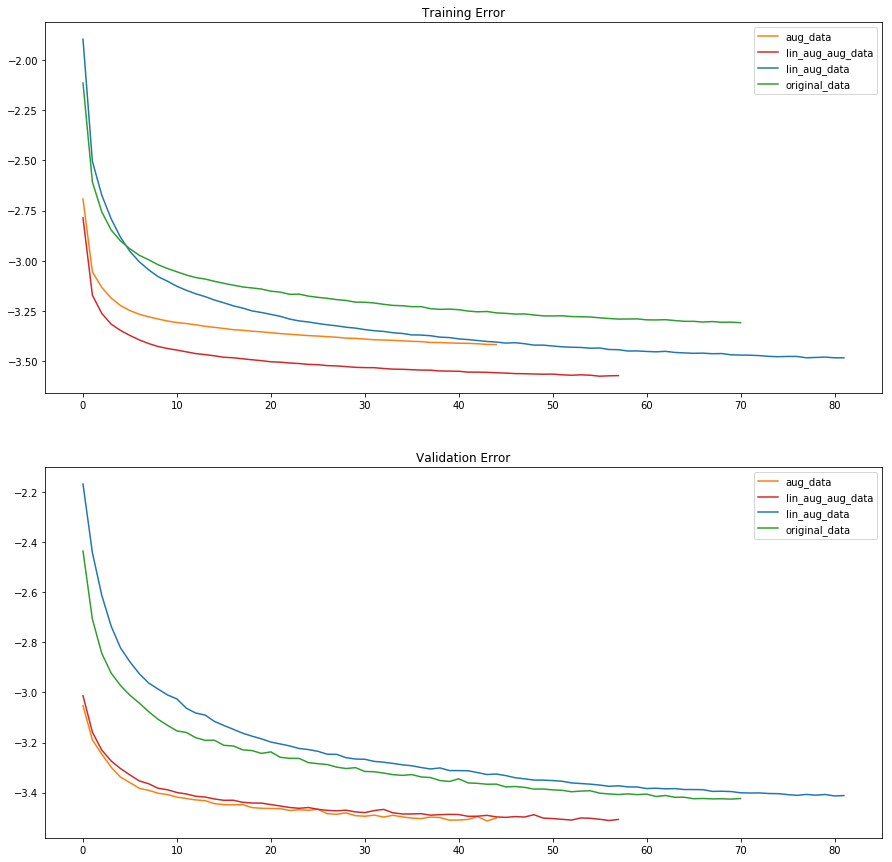

In [11]:
fig=plot_loss_dic(ae_dic)

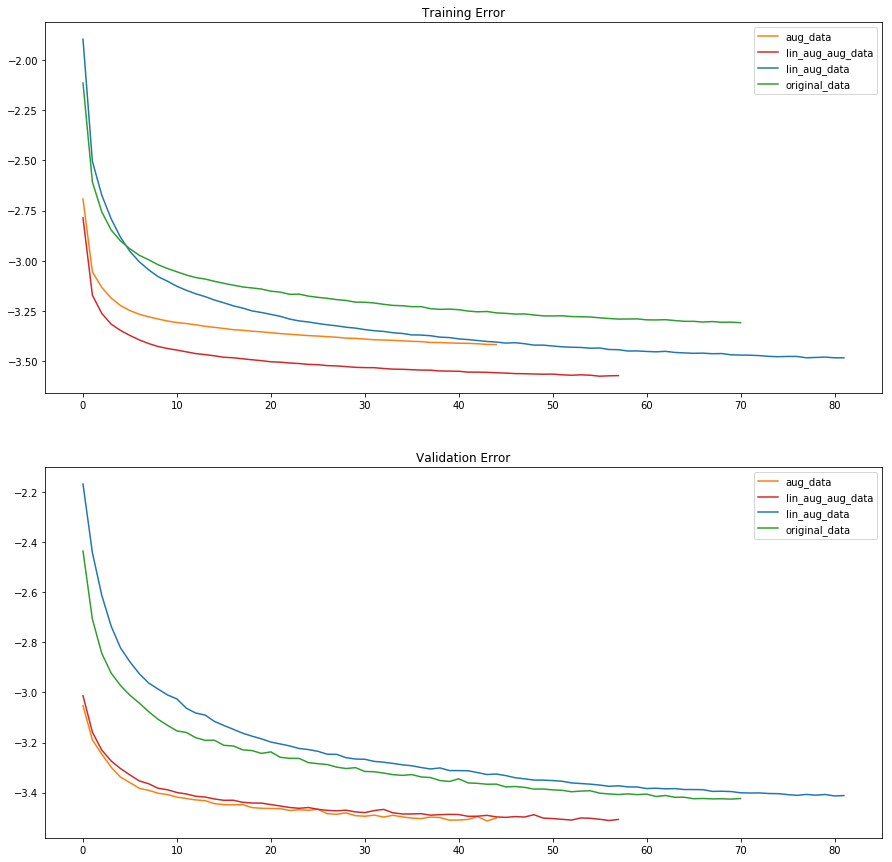

In [12]:
cwd=os.getcwd()

pic_loc=os.path.join(cwd,'ae_saves','3h','3h_dataaug_loss_pic.png') 
dic_loc=os.path.join(cwd,'ae_saves','3h','3h_dataaug_trainHistoryDict')


save_ae_dic(ae_dic,folder='aug_models/',path='./ae_saves/3h')

fig=plot_loss_dic(ae_dic)
fig.savefig(pic_loc)
save_ae_history(ae_dic,dic_loc)

In [13]:
columns=['Loss','mse loss','abs loss']
df=create_loss_param_table(ae_dic,x_test,columns)


7054/7054 [==============================] - 0s 16us/step


In [15]:
csv_loc=os.path.join(cwd,'ae_saves','3h','3h_aug_loss.csv')
df.to_csv(csv_loc)

In [ ]:
def new_datapoint(sample_pairs,x_train,pairs=False):    
    #pick set at random
    num_pairs=len(sample_pairs)
    
    if pairs=='pairs':
    #so each possible pair has an equal chance of being picked
        ridx = choice(range(1,len(sample_pairs)), 1, [comb(len(k),2) for k in sample_pairs])[0]
    elif pairs='tuple':
        ridx = choice(range(1,len(sample_pairs)), 1, [2**len(k)-2 for k in sample_pairs])[0]
    else
        ridx=np.random.randint(1, high=num_pairs)
    match_set=sample_pairs[ridx]
    
    if pairs=='pairs':
        num_match_set=2
        match_set_pair=np.random.choice(match_set,2,replace=False)
        weight_vec=sum_to_one_uniform(2)
        out=np.matmul(weight_vec,x_train[match_set_pair])
        out=np.reshape(out,(1,out.shape[0]))
    
    elif pairs=='tuple':
        num_match_set=np.randint()
        match_set_pair=np.random.choice(match_set,2,replace=False)
        weight_vec=sum_to_one_uniform(2)
        out=np.matmul(weight_vec,x_train[match_set_pair])
        out=np.reshape(out,(1,out.shape[0]))
    
    else:
    #new sample is linear combo of all in matching set
        num_match_set=len(match_set)
        weight_vec=sum_to_one_uniform(num_match_set)
        weight_vec=np.reshape(weight_vec,(1,weight_vec.shape[0]))

        out=np.matmul(weight_vec,x_train[match_set])

    return out

In [26]:
from itertools import combinations,product, permutations
list(map(lambda x: list(combinations(range(3),x)),range(2,4)))

[[(0, 1), (0, 2), (1, 2)], [(0, 1, 2)]]